In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

Using device: cuda


In [3]:
DATA_DIR = "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset"
TEST_DATA_DIR = "/kaggle/input/face-mask-dataset/data"
MODEL_SAVE_PATH = "best_mobilenet_mask_detector.pt"

In [ ]:
# Hyperparameters
batch_size = 32
learning_rate = 1e-4
epochs = 25
dropout_rate = 0.5
weight_decay = 1e-4
patience = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms
val_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "Train"), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "Validation"), transform=val_transform)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "Test"), transform=val_transform)

In [6]:
class_names = train_dataset.classes
num_classes = len(class_names)

print(f"Classes: {class_names}")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Classes: ['WithMask', 'WithoutMask']
Train samples: 10000
Validation samples: 800
Test samples: 992


In [ ]:
# data loaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

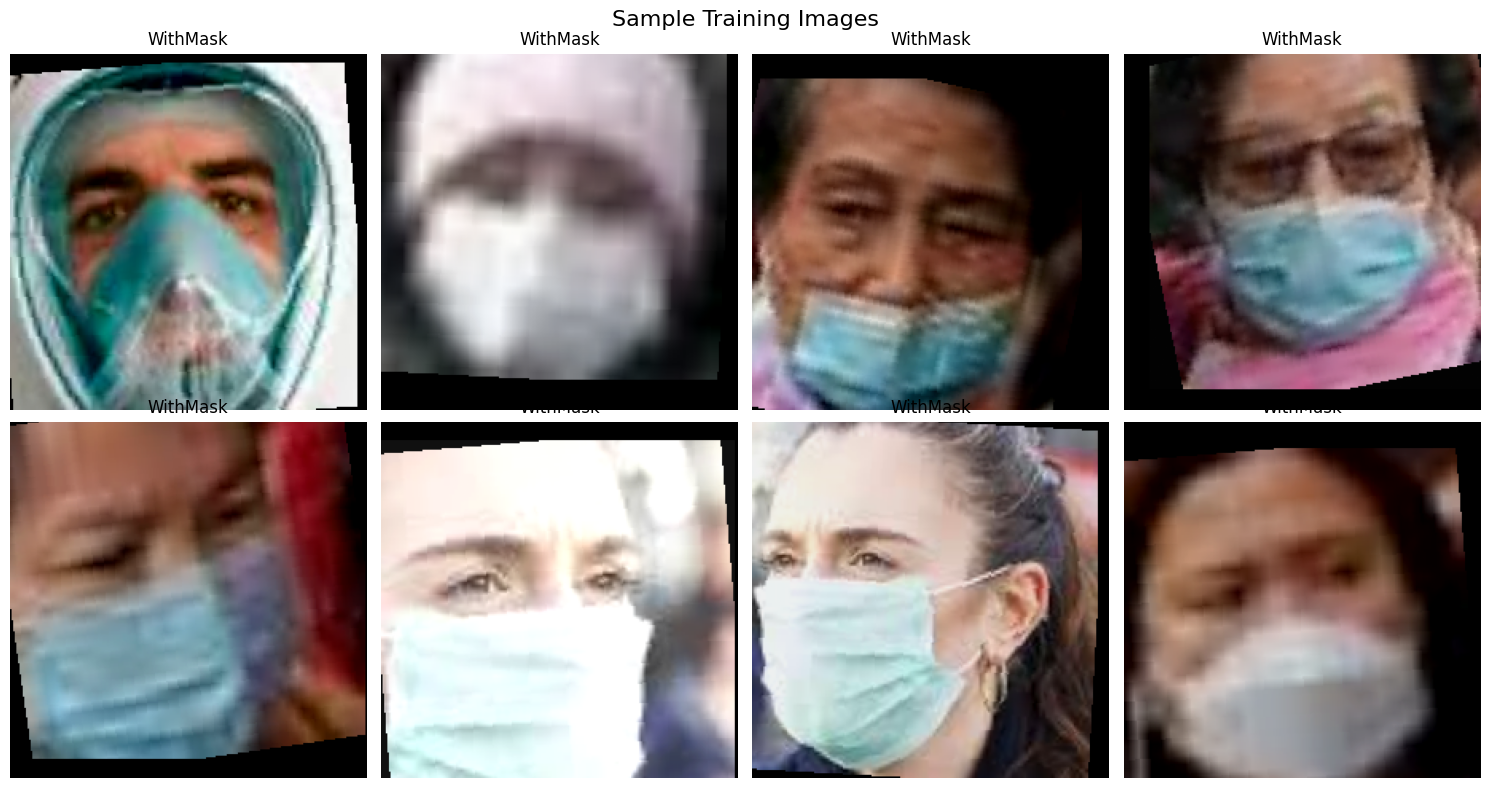

In [8]:
# Visualize
def show_sample_images(dataset, title, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    for i, ax in enumerate(axes.flatten()):
        if i < num_samples:
            img, label = dataset[i]
            img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            img = torch.clamp(img, 0, 1)
            ax.imshow(img.permute(1, 2, 0))
            ax.set_title(f"{class_names[label]}", fontsize=12)
            ax.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

show_sample_images(train_dataset, "Sample Training Images")

In [9]:
# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        logp = F.log_softmax(inputs, dim=1)
        ce_loss = F.nll_loss(logp, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

In [ ]:
# import model
model = models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.DEFAULT')
    
# freeze feature extractor
for param in model.features.parameters():
    param.requires_grad = False
        
# Custom classifier
model.classifier = nn.Sequential(
        nn.Linear(960, 1280),
        nn.Hardswish(),
        nn.Dropout(p=dropout_rate),
        nn.Linear(1280, 640),
        nn.Hardswish(),
        nn.Dropout(p=dropout_rate),
        nn.Linear(640, num_classes)
    ).to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 157MB/s]


In [ ]:
summary(model, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [32, 2]                   --
├─Sequential: 1-1                                  [32, 960, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                   [32, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                            [32, 16, 112, 112]        (432)
│    │    └─BatchNorm2d: 3-2                       [32, 16, 112, 112]        (32)
│    │    └─Hardswish: 3-3                         [32, 16, 112, 112]        --
│    └─InvertedResidual: 2-2                       [32, 16, 112, 112]        --
│    │    └─Sequential: 3-4                        [32, 16, 112, 112]        (464)
│    └─InvertedResidual: 2-3                       [32, 24, 56, 56]          --
│    │    └─Sequential: 3-5                        [32, 24, 56, 56]          (3,440)
│    └─InvertedResidual: 2-4                       [32, 24, 56, 56]          --
│    │    └─Sequential

In [ ]:
# loss function and optimizer
criterion = FocalLoss(alpha=1.0, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

# early stopping variables
best_val_acc = 0.0
patience_counter = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [13]:
# Training Functions
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
torch.manual_seed(42) 

for epoch in range(epochs):
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_acc)
    
    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print("-" * 50)
    
    # Early stopping and model saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"New best model saved! Validation Accuracy: {val_acc:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
        print("No improvement")
        
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

# Load best model
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
print("Training completed. Best model loaded.")

Batch 0/313, Loss: 0.1811
Batch 50/313, Loss: 0.0305
Batch 100/313, Loss: 0.0090
Batch 150/313, Loss: 0.0443
Batch 200/313, Loss: 0.0152
Batch 250/313, Loss: 0.0223
Batch 300/313, Loss: 0.0174
Epoch [1/25]
Train Loss: 0.0308, Train Acc: 0.9557
Val Loss: 0.0081, Val Acc: 0.9925
--------------------------------------------------
New best model saved! Validation Accuracy: 0.9925
Batch 0/313, Loss: 0.0215
Batch 50/313, Loss: 0.0103
Batch 100/313, Loss: 0.0038
Batch 150/313, Loss: 0.0163
Batch 200/313, Loss: 0.0068
Batch 250/313, Loss: 0.0024
Batch 300/313, Loss: 0.0261
Epoch [2/25]
Train Loss: 0.0148, Train Acc: 0.9806
Val Loss: 0.0098, Val Acc: 0.9875
--------------------------------------------------
No improvement
Batch 0/313, Loss: 0.0041
Batch 50/313, Loss: 0.0597
Batch 100/313, Loss: 0.0035
Batch 150/313, Loss: 0.0059
Batch 200/313, Loss: 0.0009
Batch 250/313, Loss: 0.0065
Batch 300/313, Loss: 0.0070
Epoch [3/25]
Train Loss: 0.0129, Train Acc: 0.9834
Val Loss: 0.0042, Val Acc: 0.9950

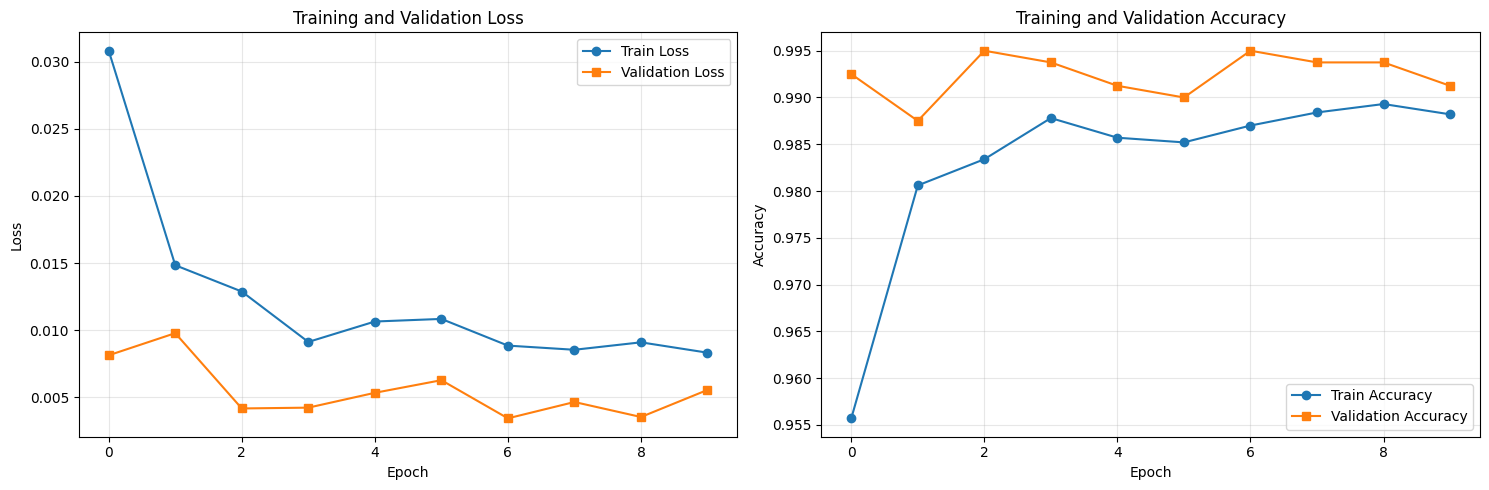

In [15]:
# Plot Training Curves
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Validation Loss', marker='s')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy curves
    ax2.plot(train_accs, label='Train Accuracy', marker='o')
    ax2.plot(val_accs, label='Validation Accuracy', marker='s')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [16]:
# Evaluation Function
def evaluate_model(model, data_loader, class_names, device, dataset_name="Test"):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    
    print(f"Evaluating on {dataset_name} set")
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            if batch_idx % 20 == 0:
                print(f'Processed {batch_idx * len(images)}/{len(data_loader.dataset)} images')
    
    accuracy = 100 * correct / total
    
    print(f"\n{dataset_name} Accuracy: {accuracy:.2f}%")
    print(f"\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    return all_preds, all_labels, accuracy

In [17]:
# Confusion Matrix Function
def plot_confusion_matrix(true_labels, predictions, class_names, accuracy, title):
    cm = confusion_matrix(true_labels, predictions)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    plt.figure(figsize=(10, 8))
    
    # Create annotations with counts and percentages
    annotations = []
    for i in range(cm.shape[0]):
        row_annotations = []
        for j in range(cm.shape[1]):
            row_annotations.append(f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)')
        annotations.append(row_annotations)
    
    # Plot heatmap
    sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'}, annot_kws={'size': 14})
    
    plt.title(f"{title}\nAccuracy: {accuracy:.2f}%", fontsize=16, pad=20)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.tight_layout()
    plt.show()

Evaluating on Validation set
Processed 0/800 images
Processed 640/800 images

Validation Accuracy: 99.50%

Classification Report:
              precision    recall  f1-score   support

    WithMask       0.99      0.99      0.99       400
 WithoutMask       0.99      0.99      0.99       400

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



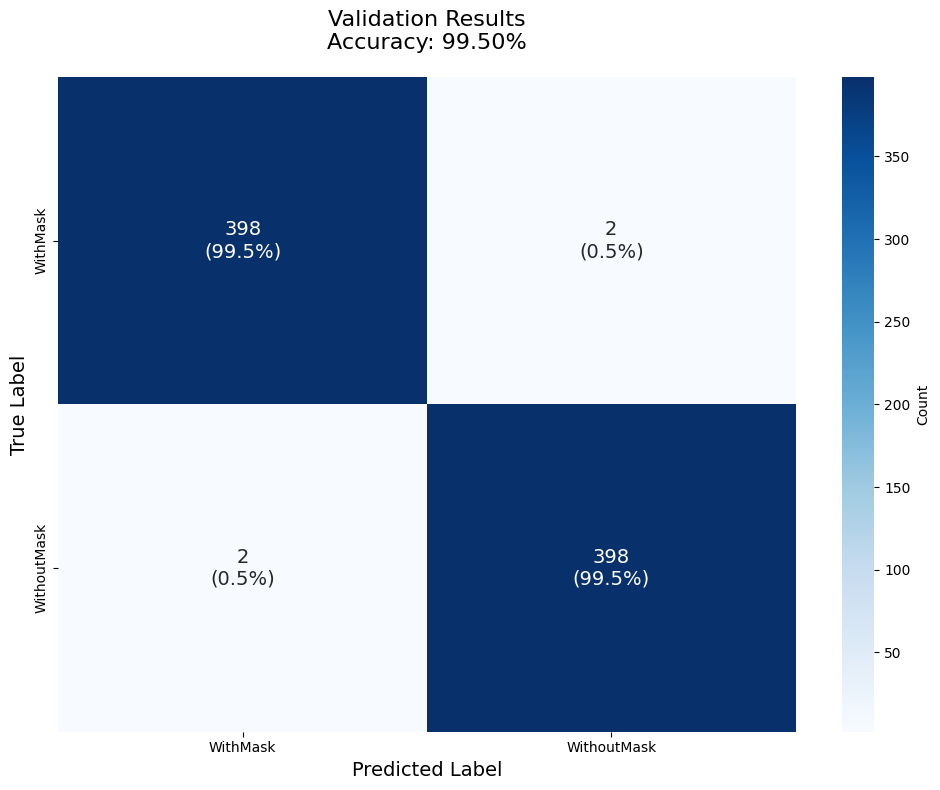

Evaluating on Test set
Processed 0/992 images
Processed 640/992 images

Test Accuracy: 98.99%

Classification Report:
              precision    recall  f1-score   support

    WithMask       0.99      0.99      0.99       483
 WithoutMask       0.99      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



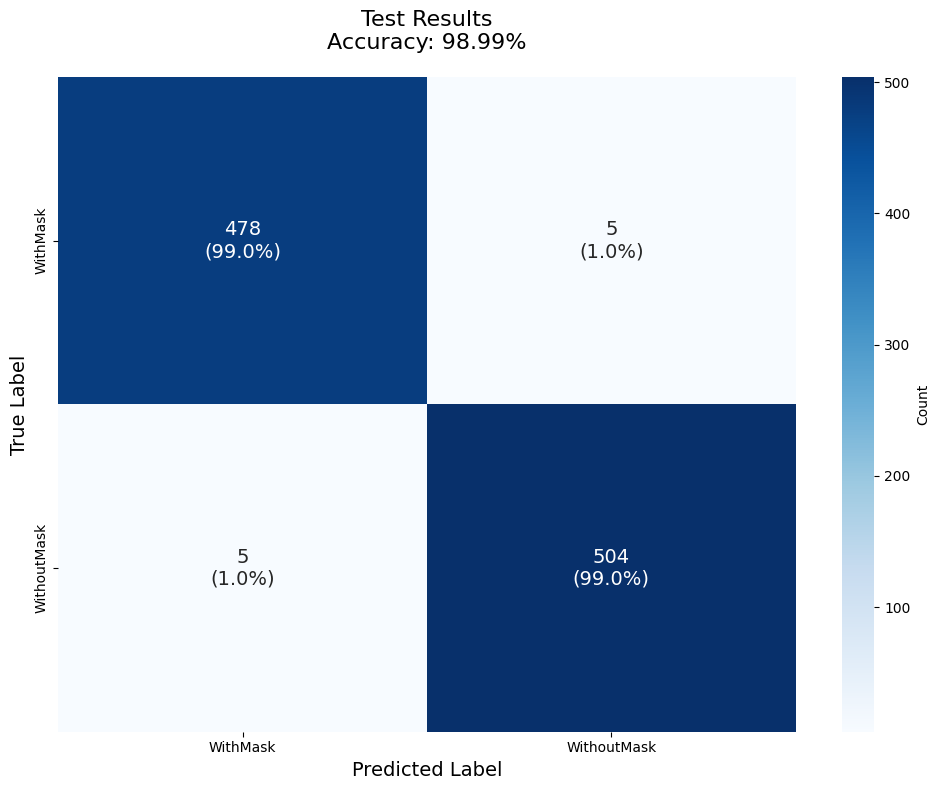

In [ ]:
# Evaluate on Validation Set
val_preds, val_labels, val_accuracy = evaluate_model(model, val_loader, class_names, device, "Validation")
plot_confusion_matrix(val_labels, val_preds, class_names, val_accuracy, "Validation Results")

# Evaluate on Test Set
test_preds, test_labels, test_accuracy = evaluate_model(model, test_loader, class_names, device, "Test")
plot_confusion_matrix(test_labels, test_preds, class_names, test_accuracy, "Test Results")


Second test dataset classes: ['with_mask', 'without_mask']
Second test dataset samples: 7553
Evaluating on Second Test Dataset set
Processed 0/7553 images
Processed 640/7553 images
Processed 1280/7553 images
Processed 1920/7553 images
Processed 2560/7553 images
Processed 3200/7553 images
Processed 3840/7553 images
Processed 4480/7553 images
Processed 5120/7553 images
Processed 5760/7553 images
Processed 6400/7553 images
Processed 7040/7553 images

Second Test Dataset Accuracy: 87.97%

Classification Report:
              precision    recall  f1-score   support

   with_mask       0.86      0.90      0.88      3725
without_mask       0.90      0.86      0.88      3828

    accuracy                           0.88      7553
   macro avg       0.88      0.88      0.88      7553
weighted avg       0.88      0.88      0.88      7553



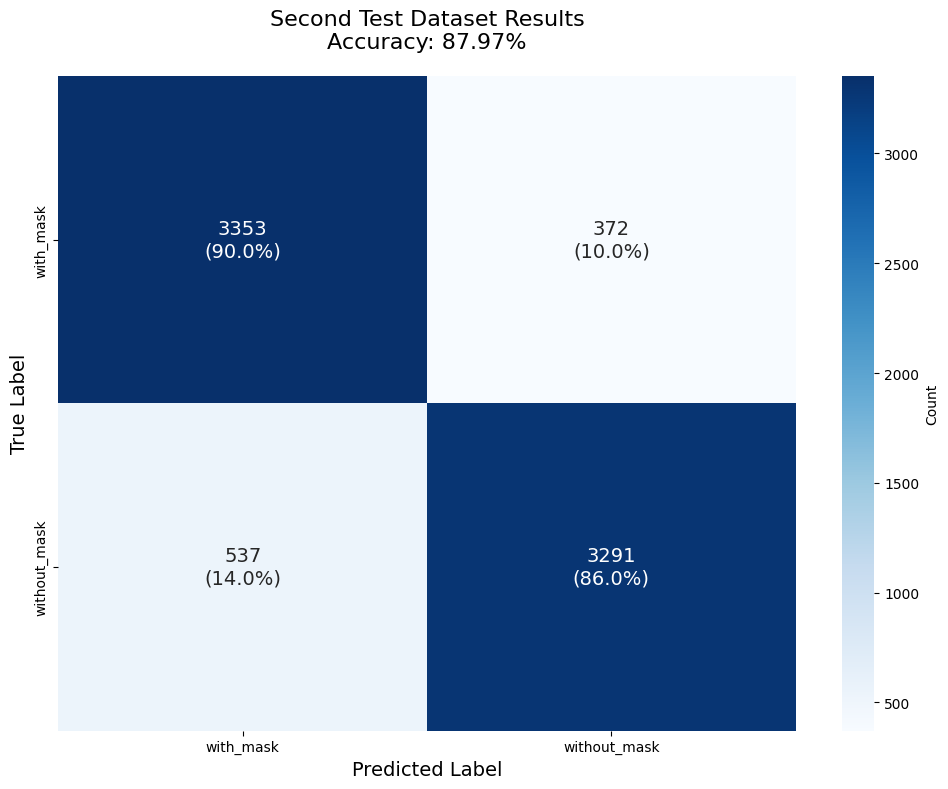

In [ ]:
try:
    second_test_dataset = datasets.ImageFolder(TEST_DATA_DIR, transform=val_transform)
    second_test_loader = DataLoader(second_test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Second test dataset classes: {second_test_dataset.classes}")
    print(f"Second test dataset samples: {len(second_test_dataset)}")
    
    # Evaluate on second dataset
    second_preds, second_labels, second_accuracy = evaluate_model(
        model, second_test_loader, second_test_dataset.classes, device, "Second Test Dataset"
    )
    plot_confusion_matrix(second_labels, second_preds, second_test_dataset.classes, 
                         second_accuracy, "Second Test Dataset Results")
    
except:
    print("Could not load second test dataset")

In [20]:
# Final Results Summary
print("FINAL RESULTS SUMMARY")
print(f"Validation Accuracy: {val_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")
if 'second_accuracy' in locals():
    print(f"Second Dataset Accuracy: {second_accuracy:.2f}%")

print(f"\n Model saved as: {MODEL_SAVE_PATH}")

FINAL RESULTS SUMMARY
Validation Accuracy: 99.50%
Test Accuracy: 98.99%
Second Dataset Accuracy: 87.97%

 Model saved as: best_mobilenet_mask_detector.pt
